# BetweenFactor

`BetweenFactor<VALUE>` is a fundamental factor in GTSAM used to represent measurements of the relative transformation (motion) between two variables of the same type `VALUE`.
Common examples include:
*   `BetweenFactorPose2`: Represents odometry measurements between 2D robot poses.
*   `BetweenFactorPose3`: Represents odometry or relative pose estimates between 3D poses.

The `VALUE` type must be a Lie Group (e.g., `Pose2`, `Pose3`, `Rot2`, `Rot3`).

The factor encodes a constraint based on the measurement `measured_`, such that the error is calculated based on the difference between the predicted relative transformation and the measured one. Specifically, if the factor connects keys $k_1$ and $k_2$ corresponding to values $X_1$ and $X_2$, and the measurement is $Z$, the factor aims to minimize:

$$ \text{error}(X_1, X_2) = \text{Log}(Z^{-1} \cdot (X_1^{-1} \cdot X_2)) $$

where `Log` is the logarithmic map for the Lie group `VALUE`, $X_1^{-1} \cdot X_2$ is the predicted relative transformation `between(X1, X2)`, and $Z^{-1}$ is the inverse of the measurement. The error vector lives in the tangent space of the identity element of the group.

`BetweenConstraint<VALUE>` is a derived class that uses a `noiseModel::Constrained` noise model, effectively enforcing the relative transformation to be exactly the measured value.

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/gtsam/slam/doc/BetweenFactor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --quiet gtsam-develop

In [2]:
import gtsam
import numpy as np
from gtsam import BetweenFactorPose2, BetweenFactorPose3
from gtsam import Pose2, Pose3, Rot3, Point3
from gtsam import NonlinearFactorGraph, Values
from gtsam import symbol_shorthand
import graphviz

X = symbol_shorthand.X

## Creating a BetweenFactor

You create a `BetweenFactor` by specifying:
1.  The keys of the two variables it connects (e.g., `X(0)`, `X(1)`).
2.  The measured relative transformation (e.g., a `Pose2` or `Pose3`).
3.  A noise model describing the uncertainty of the measurement.

In [3]:
# Example for Pose2 (2D SLAM odometry)
key1 = X(0)
key2 = X(1)
measured_pose2 = Pose2(1.0, 0.0, 0.0) # Move 1 meter forward
odometry_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.1]))

between_factor_pose2 = BetweenFactorPose2(key1, key2, measured_pose2, odometry_noise)
between_factor_pose2.print("BetweenFactorPose2: ")

# Example for Pose3 (3D SLAM odometry)
measured_pose3 = Pose3(Rot3.Yaw(0.1), Point3(0.5, 0, 0)) # Move 0.5m forward, yaw 0.1 rad
odometry_noise_3d = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.05, 0.05, 0.05, 0.1, 0.1, 0.1]))

between_factor_pose3 = BetweenFactorPose3(X(1), X(2), measured_pose3, odometry_noise_3d)
between_factor_pose3.print("\nBetweenFactorPose3: ")

BetweenFactorPose2: BetweenFactor(x0,x1)
  measured:  (1, 0, 0)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

BetweenFactorPose3: BetweenFactor(x1,x2)
  measured:  R: [
	0.995004165, -0.0998334166, 0;
	0.0998334166, 0.995004165, 0;
	0, 0, 1
]
t: 0.5   0   0
  noise model: diagonal sigmas [0.05; 0.05; 0.05; 0.1; 0.1; 0.1];


## Evaluating the Error

The `.error(values)` method calculates the error vector based on the current estimates of the variables in the `Values` object.

In [4]:
values = Values()
values.insert(X(0), Pose2(0.0, 0.0, 0.0))
values.insert(X(1), Pose2(1.1, 0.1, 0.05)) # Slightly off from measurement

# Evaluate the error for the Pose2 factor
error_vector = between_factor_pose2.error(values)
print(f"Error vector for BetweenFactorPose2: {error_vector}")

# The unwhitened error is Log(Z^-1 * (X1^-1 * X2))
pose0 = values.atPose2(X(0))
pose1 = values.atPose2(X(1))
predicted_relative = pose0.between(pose1)
error_pose = measured_pose2.inverse() * predicted_relative
unwhitened_error_expected = Pose2.Logmap(error_pose)
print(f"Manual unwhitened error calculation: {unwhitened_error_expected}")
print(f"Factor unwhitened error: {between_factor_pose2.unwhitenedError(values)}")

# The whitened error (returned by error()) applies the noise model
# For diagonal noise model, error_vector = unwhitened_error / sigmas
sigmas = odometry_noise.sigmas()
whitened_expected = unwhitened_error_expected / sigmas
print(f"Manually whitened error: {whitened_expected}")

Error vector for BetweenFactorPose2: 0.3750000000000002
Manual unwhitened error calculation: [0.10247917 0.09747917 0.05      ]
Factor unwhitened error: [0.1  0.1  0.05]
Manually whitened error: [0.51239583 0.48739583 0.5       ]


## Visualization

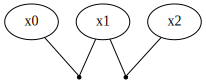

In [5]:
graph = NonlinearFactorGraph()
graph.add(between_factor_pose2)
graph.add(between_factor_pose3)

dot_string = graph.dot(values)
graphviz.Source(dot_string)